# Install and import necessary libraries

In [ ]:
# Check GPU status
!nvidia-smi

Wed Jun 11 07:35:03 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   42C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
!pip install numpy
!pip install pandas

In [ ]:
import numpy as np
import pandas as pd
import shutil
import sys
import tqdm.notebook as tq
from collections import defaultdict
import os
import json

import torch
import torch.nn as nn

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
print(device)
print(torch.cuda.is_available())

cuda
True


# Data preprocessing

## Load the data to a dataframe

In [ ]:
data_dir = r'/content/drive/MyDrive/data'
file_path = r"/content/drive/MyDrive/data/arxiv-metadata-oai-snapshot.json"

chunk_size = 10000
chunks = []

for chunk in pd.read_json(file_path, lines=True, chunksize=chunk_size):
    chunks.append(chunk)


data_df = pd.concat(chunks, ignore_index=True)

In [ ]:
print(data_df.shape)

df = data_df.copy()
df = df.drop_duplicates()
print(df.shape)

(2683176, 14)


In [ ]:
data_df.head(5)

,id,submitter,authors,title,comments,journal-ref,doi,report-no,categories,license,abstract,versions,update_date,authors_parsed
0,704.0001,Pavel Nadolsky,"C. Bal\'azs, E. L. Berger, P. M. Nadolsky, C.-...",Calculation of prompt diphoton production cros...,"37 pages, 15 figures; published version","Phys.Rev.D76:013009,2007",10.1103/PhysRevD.76.013009,ANL-HEP-PR-07-12,hep-ph,None,A fully differential calculation in perturba...,"[{'version': 'v1', 'created': 'Mon, 2 Apr 2007...",2008-11-26,"[[Balázs, C., ], [Berger, E. L., ], [Nadolsky,..."
1,704.0002,Louis Theran,Ileana Streinu and Louis Theran,Sparsity-certifying Graph Decompositions,To appear in Graphs and Combinatorics,None,None,None,math.CO cs.CG,http://arxiv.org/licenses/nonexclusive-distrib...,"We describe a new algorithm, the $(k,\ell)$-...","[{'version': 'v1', 'created': 'Sat, 31 Mar 200...",2008-12-13,"[[Streinu, Ileana, ], [Theran, Louis, ]]"
2,704.0003,Hongjun Pan,Hongjun Pan,The evolution of the Earth-Moon system based o...,"23 pages, 3 figures",None,None,None,physics.gen-ph,None,The evolution of Earth-Moon system is descri...,"[{'version': 'v1', 'created': 'Sun, 1 Apr 2007...",2008-01-13,"[[Pan, Hongjun, ]]"
3,704.0004,David Callan,David Callan,A determinant of Stirling cycle numbers counts...,11 pages,None,None,None,math.CO,None,We show that a determinant of Stirling cycle...,"[{'version': 'v1', 'created': 'Sat, 31 Mar 200...",2007-05-23,"[[Callan, David, ]]"
4,704.0005,Alberto Torchinsky,Wael Abu-Shammala and Alberto Torchinsky,From dyadic $\Lambda_{\alpha}$ to $\Lambda_{\a...,None,"Illinois J. Math. 52 (2008) no.2, 681-689",None,None,math.CA math.FA,None,In this paper we show how to compute the $\L...,"[{'version': 'v1', 'created': 'Mon, 2 Apr 2007...",2013-10-15,"[[Abu-Shammala, Wael, ], [Torchinsky, Alberto, ]]"


## Data extraction:
- Columns for features:
 - Abstract
 - Title

- Columns for labels:
 - Categories

In [ ]:
cols = ['abstract', 'title', 'categories']
meta_df = data_df[cols]

In [ ]:
meta_df.head(5)

,abstract,title,categories
0,A fully differential calculation in perturba...,Calculation of prompt diphoton production cros...,hep-ph
1,"We describe a new algorithm, the $(k,\ell)$-...",Sparsity-certifying Graph Decompositions,math.CO cs.CG
2,The evolution of Earth-Moon system is descri...,The evolution of the Earth-Moon system based o...,physics.gen-ph
3,We show that a determinant of Stirling cycle...,A determinant of Stirling cycle numbers counts...,math.CO
4,In this paper we show how to compute the $\L...,From dyadic $\Lambda_{\alpha}$ to $\Lambda_{\a...,math.CA math.FA


## Label preprocessing:


### Step 1: Because each row of the column categories can have many categories: math.CO, cs.CG, etc, therefore we need to split those values to a list

In [ ]:
# Preprocess the label data
# Step 1: Extract the categories from a string to a list
meta_df['category'] = meta_df['categories'].str.split()

meta_df.head(5)

<ipython-input-8-105062017>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meta_df['category'] = meta_df['categories'].str.split()


,abstract,title,categories,category
0,A fully differential calculation in perturba...,Calculation of prompt diphoton production cros...,hep-ph,[hep-ph]
1,"We describe a new algorithm, the $(k,\ell)$-...",Sparsity-certifying Graph Decompositions,math.CO cs.CG,"[math.CO, cs.CG]"
2,The evolution of Earth-Moon system is descri...,The evolution of the Earth-Moon system based o...,physics.gen-ph,[physics.gen-ph]
3,We show that a determinant of Stirling cycle...,A determinant of Stirling cycle numbers counts...,math.CO,[math.CO]
4,In this paper we show how to compute the $\L...,From dyadic $\Lambda_{\alpha}$ to $\Lambda_{\a...,math.CA math.FA,"[math.CA, math.FA]"


### Step 2: Remove the tail of the categories: math.CO -> math (remove .CO), cs.CG -> cs (remove .CG)

In [ ]:
# Step 2: Remove sub-category
meta_df['main_category'] = meta_df.category.apply(lambda x: [a.split('.')[0] for a in x])
meta_df.drop(columns=['category', 'categories'], inplace=True)

meta_df.head(5)

In [ ]:
meta_df.shape

NameError: name 'meta_df' is not defined

### Step 3: Apply encoding to the label data

#### Step 3.1: Apply label encoding for each of the label

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
labels = mlb.fit_transform(meta_df['main_category'])

labels

NameError: name 'meta_df' is not defined

In [ ]:
print(f'Number of rows: {len(labels)}')
print(f'Categories: {mlb.classes_}')
print(f'Values of row 2: {labels[1]}')

#### Step 3.2: Concat the data after apply label encoding

In [ ]:
df = pd.concat([meta_df[['abstract', 'title']], pd.DataFrame(labels)], axis=1)
df.columns = ['abstract', 'title'] + list(mlb.classes_)

df.head(5)

In [ ]:
df.shape

### Step 4 Remove the categories that have a small number of articles

#### Step 4.1: Get the frequencies of each category

In [ ]:
# Step 4.1: Calculate the frequency of each tag
columns = df.columns

category_frequency = df[columns[2:]].sum() / df.shape[0]
category_frequency

,0
acc-phys,0.000018
adap-org,0.000218
alg-geom,0.000530
ao-sci,0.000006
astro-ph,0.133172
atom-ph,0.000046
bayes-an,0.000006
chao-dyn,0.000894
chem-ph,0.000094
cmp-lg,0.000333


#### Step 4.2: Plot the frequencies

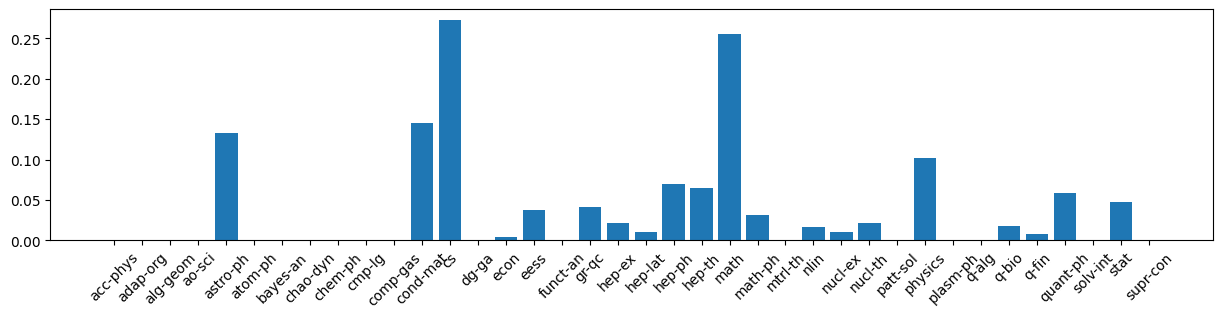

In [ ]:
import matplotlib.pyplot as plt

# Step 4.2: Draw the bar chart of frequency
plt.figure(figsize=(15, 3))
plt.bar(category_frequency.index, category_frequency.values)
plt.xticks(rotation=45)
plt.show()

#### Step 4.3: Set a threshold to keep categories that have the value of frequency larger than it (Threshold = 0.05)

In [ ]:
# Step 4.3: Pick a threshold and remove the category with frequency <= threshold
freq_threshold = 0.05

# Remove categories that has the value of frequency lower than the threshold = 0.05
qualified_cols = category_frequency.index[category_frequency.values > freq_threshold]
qualified_df = df[['abstract', 'title'] + list(qualified_cols)]

# Remove rows that do not belong to any categories means that all the values of qualified columns are zeros
qualified_df = qualified_df.loc[qualified_df[qualified_cols].sum(axis=1) > 0]


print(f'List of orginal categories: {category_frequency.index}')
print(f'Number of orginal categories: {len(category_frequency)}')
print(f'List of qualified columns: {qualified_cols.values}')
print(f'Number of qualified columns: {len(qualified_cols)}')

List of orginal categories: Index(['acc-phys', 'adap-org', 'alg-geom', 'ao-sci', 'astro-ph', 'atom-ph',
       'bayes-an', 'chao-dyn', 'chem-ph', 'cmp-lg', 'comp-gas', 'cond-mat',
       'cs', 'dg-ga', 'econ', 'eess', 'funct-an', 'gr-qc', 'hep-ex', 'hep-lat',
       'hep-ph', 'hep-th', 'math', 'math-ph', 'mtrl-th', 'nlin', 'nucl-ex',
       'nucl-th', 'patt-sol', 'physics', 'plasm-ph', 'q-alg', 'q-bio', 'q-fin',
       'quant-ph', 'solv-int', 'stat', 'supr-con'],
      dtype='object')
Number of orginal categories: 38
List of qualified columns: ['astro-ph' 'cond-mat' 'cs' 'hep-ph' 'hep-th' 'math' 'physics' 'quant-ph']
Number of qualified columns: 8


In [ ]:
print(f'Original df: {df.shape}')
print(f'Qualified df: {qualified_df.shape}')

Original df: (2683176, 40)
Qualified df: (2497567, 10)


## Remove duplicated data

In [ ]:
print(f"Number of duplicated rows: {qualified_df.duplicated().sum()}")

qualified_df = qualified_df.drop_duplicates()
print(f"Number of duplicated rows: {qualified_df.duplicated().sum()}")

## Subsample the data

In [ ]:
df_data = qualified_df.sample(n = 60000, random_state = 42)
print(f'Shape of dataframe: {df_data.shape}')
df_data.head(10)

Shape of dataframe: (60000, 10)


,abstract,title,astro-ph,cond-mat,cs,hep-ph,hep-th,math,physics,quant-ph
585705,We report on our ongoing effort to measure t...,Measuring the Boltzmann constant by mid-infrar...,0,0,0,0,0,0,1,1
340055,We report the observation of transverse elec...,Room-temperature transverse-electric polarized...,0,1,0,0,0,0,1,0
1844530,We propose a novel combinatorial stochastic-...,Combinatorial Stochastic-Greedy Bandit,0,0,1,0,0,1,0,0
1655354,"Estimating the dissipation, or the entropy p...",Utilizing time-series measurements for entropy...,0,1,0,0,0,0,0,0
81039,We show that the absence of pre-switching os...,Macrospin model of incubation delay due to the...,0,1,0,0,0,0,0,0
298358,2011 was a successful year for the GREGOR pr...,The GREGOR solar telescope on Tenerife,1,0,0,0,0,0,0,0
1598806,"We propose Fast text2StyleGAN, a natural lan...",Text-Free Learning of a Natural Language Inter...,0,0,1,0,0,0,0,0
503212,We experimentally demonstrate optical Mach-Z...,Highly stable polarization independent Mach-Ze...,0,0,0,0,0,0,1,1
1793058,Highly specific datasets of scientific liter...,Interactive Distillation of Large Single-Topic...,0,0,1,0,0,0,0,0
799100,Stanley proved that for any centrally symmet...,A lower bound theorem for centrally symmetric ...,0,0,0,0,0,1,0,0


## Combine the "abstract" and "title" columns into one column

In [ ]:
df_data['combined'] = df_data['title'] + '. ' + df_data['abstract']
df_data.drop(columns=['title', 'abstract'], axis=1, inplace=True)

In [ ]:
print(f'Shape of dataframe: {df_data.shape}')
print(f"Dataframe's columns: {df_data.columns.values}")
df_data.head(10)

Shape of dataframe: (60000, 9)
Dataframe's columns: ['astro-ph' 'cond-mat' 'cs' 'hep-ph' 'hep-th' 'math' 'physics' 'quant-ph'
 'combined']


,astro-ph,cond-mat,cs,hep-ph,hep-th,math,physics,quant-ph,combined
585705,0,0,0,0,0,0,1,1,Measuring the Boltzmann constant by mid-infrar...
340055,0,1,0,0,0,0,1,0,Room-temperature transverse-electric polarized...
1844530,0,0,1,0,0,1,0,0,Combinatorial Stochastic-Greedy Bandit. We p...
1655354,0,1,0,0,0,0,0,0,Utilizing time-series measurements for entropy...
81039,0,1,0,0,0,0,0,0,Macrospin model of incubation delay due to the...
298358,1,0,0,0,0,0,0,0,The GREGOR solar telescope on Tenerife. 2011...
1598806,0,0,1,0,0,0,0,0,Text-Free Learning of a Natural Language Inter...
503212,0,0,0,0,0,0,1,1,Highly stable polarization independent Mach-Ze...
1793058,0,0,1,0,0,0,0,0,Interactive Distillation of Large Single-Topic...
799100,0,0,0,0,0,1,0,0,A lower bound theorem for centrally symmetric ...


## Spliting the data into train, validation and test set

In [ ]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(df_data, test_size=0.3, random_state=42)
test_set, val_set = train_test_split(test_set, test_size=0.5, random_state=42)

In [ ]:
print(f'Shape of train set: {train_set.shape}')
print(f'Shape of validation set: {val_set.shape}')
print(f'Shape of test set: {test_set.shape}')

Shape of train set: (42000, 9)
Shape of validation set: (9000, 9)
Shape of test set: (9000, 9)


In [ ]:
print(f'Train set:\n{train_set.head(5)}')
print(f'Validation set:\n{val_set.head(5)}')
print(f'Test set:\n{test_set.head(5)}')

# Multi-label text classification using Bert model

## Define hyperparameters

In [ ]:
MAX_LEN = 256
TRAIN_BATCH_SIZE = 32
VAL_BATCH_SIZE = 32
TEST_BATCH_SIZE = 32
EPOCHS = 20
LEARNING_RATE = 1e-05
THRESHOLD = 0.5 # Threshold for the sigmoid activation function at the output layer

## Apply word embedding by using BertTokenizer

In [ ]:
from transformers import BertTokenizer, BertModel

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
# Test the tokenizer

test_text = "A sample sentence to test the BertTokenizer. I want to apply this sentence to test this BertTokenizer."

encodings = tokenizer.encode_plus(test_text,
                                  add_special_tokens=True,
                                  max_length=50,
                                  truncation=True,
                                  padding="max_length",
                                  return_attention_mask=True,
                                  return_tensors="pt")

encodings

{'input_ids': tensor([[  101,  1037,  7099,  6251,  2000,  3231,  1996, 14324, 18715, 18595,
          6290,  1012,  1045,  2215,  2000,  6611,  2023,  6251,  2000,  3231,
          2023, 14324, 18715, 18595,  6290,  1012,   102,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0]])}

In [ ]:
train_set['combined']

,combined
2270619,Landau Level Mixing and Levitation of Extended...
151058,Realization of the Exactly Solvable Kitaev Hon...
1219913,Online Multi-agent Reinforcement Learning for ...
2066395,Smart Kanata: A Framework for Autonomous Decis...
1733558,Exploring Lottery Prompts for Pre-trained Lang...
...,...
1119029,Global Occurrence and Chemical Impact of Strat...
2102359,Emergence of Topological Non-Fermi Liquid Phas...
1048344,Catching butterflies in the sky: Extended cata...
785809,Edmonds' Branching Theorem in Digraphs without...


### Define a custom class to apply word embedding for the dataset

In [ ]:
class CustomDataset(torch.utils.data.Dataset):
  def __init__(self, df, tokenizer, max_len, target_list):
    self.tokenizer = tokenizer
    self.df = df
    self.title = list(df['combined'])
    self.targets = self.df[target_list].values
    self.max_len = max_len

  def __len__(self):
    return len(self.title)

  def __getitem__(self, index):
    title = str(self.title[index])
    title = ' '.join(title.split())
    inputs = self.tokenizer.encode_plus(title,
                                        None,
                                        add_special_tokens=True,
                                        max_length=self.max_len,
                                        padding='max_length',
                                        return_token_type_ids=True,
                                        truncation=True,
                                        return_attention_mask=True,
                                        return_tensors='pt')
    return {
        'input_ids': inputs['input_ids'].flatten(),
        'attention_mask': inputs['attention_mask'].flatten(),
        'token_type_ids': inputs['token_type_ids'].flatten(),
        'targets': torch.FloatTensor(self.targets[index]),
        'title': title
    }

In [ ]:
target_list = df_data.columns
print(target_list.values)

# We only get the columns that represent the categories but not the "combined" column
target_list = target_list[:-1]
print(target_list.values)

['astro-ph' 'cond-mat' 'cs' 'hep-ph' 'hep-th' 'math' 'physics' 'quant-ph'
 'combined']
['astro-ph' 'cond-mat' 'cs' 'hep-ph' 'hep-th' 'math' 'physics' 'quant-ph']


In [ ]:
train_dataset = CustomDataset(train_set, tokenizer, MAX_LEN, target_list)
val_dataset = CustomDataset(val_set, tokenizer, MAX_LEN, target_list)
test_dataset = CustomDataset(test_set, tokenizer, MAX_LEN, target_list)

In [ ]:
next(iter(train_dataset))

{'input_ids': tensor([  101, 28570,  2504,  6809,  1998, 11902, 12516,  1997,  3668,  2163,
          1999,  2048,  9646,  1012,  2057,  2817,  1996,  3896,  1997,  6809,
          1997,  2367, 28570,  3798,  2006,  1996, 19320,  1997,  2028,  1011,
          2303,  2163,  1010,  1999,  1996,  3739,  1997,  1037,  2844,  6375,
          8060,  2492,  1998,  1037,  6721,  4022,  1999,  2048,  9646,  1012,
          2057,  2224,  1037,  2566, 20689, 14479,  3512,  3921,  1998,  4503,
          1037, 11778,  4935,  1999,  2119,  1996,  3997,  1998,  5744,  2791,
          1997,  1996,  6721,  4022,  1012,  2057,  2424,  1996, 19320,  1997,
          1996,  3668,  2163,  5670,  1063,  1032,  7861, 10745,  1065,  1010,
          1998,  1996,  3815,  1997, 11902, 12516,  2003, 14267,  2000,  1002,
          1006,  1050,  1009,  1015,  1013,  1016,  1007,  1013,  1038,  1034,
          1017,  1002,  2005,  2844,  8060,  2492,  1010,  2073,  1002,  1038,
          1002,  2003,  1996,  8060,  2

In [ ]:
# Load the train, val and test dataset to corresponding DataLoader

train_data_loader = torch.utils.data.DataLoader(train_dataset,
                                                batch_size=TRAIN_BATCH_SIZE,
                                                shuffle=True,
                                                num_workers=0)

val_data_loader = torch.utils.data.DataLoader(val_dataset,
                                              batch_size=VAL_BATCH_SIZE,
                                              shuffle=False,
                                              num_workers=0)

test_data_loader = torch.utils.data.DataLoader(test_dataset,
                                               batch_size=TEST_BATCH_SIZE,
                                               shuffle=False,
                                               num_workers=0)

## Define a class for the Bert Model

In [ ]:
class BERTClass(torch.nn.Module):
  def __init__(self):
    super(BERTClass, self).__init__()
    self.bert_model = BertModel.from_pretrained('bert-base-uncased', return_dict=True)
    self.dropout = torch.nn.Dropout(0.3)
    self.linear = torch.nn.Linear(768, len(target_list))

  def forward(self, input_ids, attention_mask, token_type_ids):
    output = self.bert_model(input_ids,
                             attention_mask=attention_mask,
                             token_type_ids=token_type_ids)
    output_dropout = self.dropout(output.pooler_output)
    output = self.linear(output_dropout)
    return output

In [ ]:
model = BERTClass()
model.to(device)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

BERTClass(
  (bert_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwi

## Define the loss function and optimizer

In [ ]:
# Loss function
def loss_func(outputs, targets):
  return torch.nn.BCEWithLogitsLoss()(outputs, targets)

In [ ]:
# from transformers import AdamW
# Optimizer

optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
# optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)

## Define a function to train the model in 1 epoch

In [ ]:
def train_model(training_loader, model, optimizer):
  losses = []
  correct_predictions = 0
  num_samples = 0

  # Set the model to training mode: Activate dropout and batchnorm
  model.train()

  loop = tq.tqdm(enumerate(training_loader), total=len(training_loader),
                 leave=True, colour='steelblue')

  # Iterate through the training loader
  for batch_idx, data in loop:
    ids = data['input_ids'].to(device, dtype = torch.long)
    attention_mask = data['attention_mask'].to(device, dtype = torch.long)
    token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
    targets = data['targets'].to(device, dtype = torch.float)

    # Forward propagation:
    outputs = model(ids, attention_mask, token_type_ids)
    loss = loss_func(outputs, targets)
    losses.append(loss.item())

    # Training accuracy, apply sigmoid and round (apply thresh 0.5 means that values that are <= 0.5 will be rounded to 0 and values that are > 0.5 will be rounded to 1)
    # Git
    outputs = torch.sigmoid(outputs).cpu().detach().numpy().round()
    targets = targets.cpu().detach().numpy()

    correct_predictions += np.sum(outputs == targets)
    num_samples += targets.size

    # Backward propagation:
    optimizer.zero_grad()
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

    # Gradient descent step:
    optimizer.step()

  return model, float(correct_predictions) / num_samples, np.mean(losses)

## Define a function to evaluate the model while training

In [ ]:
def eval_model(validation_loader, model, mul_thresh=None):
  losses = []
  correct_predictions = 0
  num_samples = 0

  # Set the model to eval mode: Turn off dropout, fix batch norm
  model.eval()

  with torch.no_grad():
    for batch_idx, data in enumerate(validation_loader, 0):
      ids = data['input_ids'].to(device, dtype = torch.long)
      attention_mask = data['attention_mask'].to(device, dtype = torch.long)
      token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
      targets = data['targets'].to(device, dtype = torch.float)

      # Forward once
      outputs = model(ids, attention_mask, token_type_ids)
      loss = loss_func(outputs, targets)
      losses.append(loss.item())

      if mul_thresh is None:
        # Single threshold
        outputs = torch.sigmoid(outputs).cpu().detach().numpy().round()
      else:
        # Multiple thresholds
        outputs = torch.sigmoid(outputs).cpu().detach().numpy()
        outputs = (outputs >= mul_thresh).astype(int)

      targets = targets.cpu().detach().numpy()

      # print('Validation')
      # print(f'Outputs: {outputs}, type: {type(outputs)}, length: {len(outputs)}')
      # print(f'Targets: {targets}, type: {type(targets)}, length: {len(targets)}')

      correct_predictions += np.sum(outputs == targets)
      num_samples += targets.size

    return float(correct_predictions) / num_samples, np.mean(losses)

## Model Training

In [ ]:
history = defaultdict(list)
best_accuracy = 0

for epoch in range(1, EPOCHS + 1):
  print(f'EPOCH {epoch} / {EPOCHS}')
  model, train_acc, train_loss = train_model(train_data_loader, model)
  val_acc, val_loss = eval_model(val_data_loader, model)

  print(f'Train Accuracy: {train_acc:.4f}, Train Loss: {train_loss:.4f}\n Val Accuracy: {val_acc:.4f}, Val Loss: {val_loss:.4f}')

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  # Save the parameters of the best model
  if val_acc > best_accuracy:
    torch.save(model.state_dict(), os.path.join(data_dir, "output", "best_model_state.bin"))
    best_accuracy = val_acc

EPOCH 1 / 10


  0%|          | 0/1313 [00:00<?, ?it/s]

Train Accuracy: 0.9353, Train Loss: 0.1927
 Val Accuracy: 0.9593, Val Loss: 0.1165
EPOCH 2 / 10


  0%|          | 0/1313 [00:00<?, ?it/s]

Train Accuracy: 0.9616, Train Loss: 0.1097
 Val Accuracy: 0.9616, Val Loss: 0.1054
EPOCH 3 / 10


  0%|          | 0/1313 [00:00<?, ?it/s]

## Plot the graph of Training and Validation accuracy score

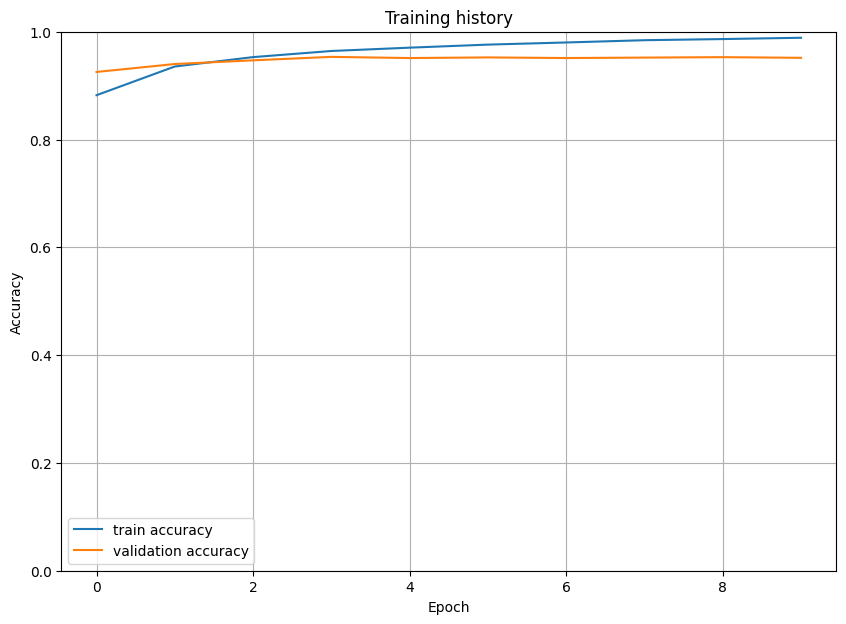

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.ylim([0, 1])
plt.grid()

## Find the optimal threshold for each label

In [ ]:
# Loading the pretrained model (the best model)
model = BERTClass()
model.load_state_dict(torch.load(os.path.join(data_dir, "output", "best_model_state.bin")))
model = model.to(device)

### Find the probabilities and labels of the validation set

In [ ]:
def find_val_probs_labels(validation_loader, model):
  probabilities = []
  true_labels = []

  model.eval()

  with torch.no_grad():
    for batch_idx, data in enumerate(validation_loader, 0):
      ids = data['input_ids'].to(device, dtype = torch.long)
      attention_mask = data['attention_mask'].to(device, dtype = torch.long)
      token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
      targets = data['targets'].to(device, dtype = torch.float)

      outputs = model(ids, attention_mask, token_type_ids)
      outputs = torch.sigmoid(outputs).cpu().detach().numpy().tolist()
      targets = targets.cpu().detach().numpy().tolist()

      # print('Outputs: ', outputs)
      # print('Length of outputs: ', len(outputs))
      # print('Len of targets: ', len(targets))
      # print('Targets: ', targets)

      probabilities.extend(outputs)
      true_labels.extend(targets)

  return probabilities, true_labels

In [ ]:
probabilities, true_labels = find_val_probs_labels(val_data_loader, model)

print('Probablities: ',probabilities)
print('True labels: ', true_labels)

Probablities:  [[0.0007759075961075723, 0.004026922397315502, 0.001922701601870358, 0.002135932445526123, 0.01744915544986725, 0.9827653765678406, 0.0019672024063766003, 0.020088231191039085], [0.0006990539841353893, 0.0020316403824836016, 0.9969035983085632, 0.0006643352098762989, 0.0008461112738586962, 0.04777875170111656, 0.0031673891935497522, 0.0016589927254244685], [0.0017589235212653875, 0.0013291939394548535, 0.9959233999252319, 0.0014032365288585424, 0.0011306809028610587, 0.0037351592909544706, 0.0024944227188825607, 0.0008892560144886374], [0.0006434966926462948, 0.0010788609506562352, 0.9853690266609192, 0.0005465089925564826, 0.00060369010316208, 0.12732352316379547, 0.0031379933934658766, 0.0005817663623020053], [0.0014525094302371144, 0.0025609633885324, 0.002046538982540369, 0.00188744708430022, 0.011580031365156174, 0.9950810670852661, 0.004563531372696161, 0.0016678172396495938], [0.009011519141495228, 0.03810879588127136, 0.03755998611450195, 0.0071919020265340805, 0

### Method 1: ROC

In [ ]:
from sklearn.metrics import roc_curve

def find_optimal_roc_thresholds(probabilities, true_labels):
  optimal_roc_thresholds = []

  probs = np.array(probabilities)
  labels = np.array(true_labels)

  for i in range(labels.shape[1]):
    fpr, tpr, thresholds = roc_curve(labels[:, i], probs[:, i])
    youdens_index = tpr - fpr

    optimal_roc_threshold = thresholds[np.argmax(youdens_index)]
    optimal_roc_thresholds.append(optimal_roc_threshold)

  return optimal_roc_thresholds

In [ ]:
optimal_roc_thresholds = find_optimal_roc_thresholds(probabilities, true_labels)
optimal_roc_thresholds = np.array(optimal_roc_thresholds)
print(optimal_roc_thresholds)

[0.06374481 0.09256332 0.2210799  0.02074483 0.01550202 0.22989033
 0.08821227 0.02416834]


### Method 2: PRC

In [ ]:
def find_prc_thresholds(probabilities, true_labels):
    optimal_prc_thresholds = []
    probs = np.array(probabilities)
    labels = np.array(true_labels)

    for i in range(labels.shape[1]):
        # Compute precision, recall, and thresholds using PRC
        precision, recall, thresholds = precision_recall_curve(labels[:, i], probs[:, i])

        # Calculate F1-scores for each threshold
        f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)  # Avoid division by zero

        # Find threshold maximizing F1-score
        optimal_idx = np.argmax(f1_scores)
        optimal_prc_threshold = thresholds[optimal_idx] if optimal_idx < len(thresholds) else 0.5  # Fallback to 0.5 if no threshold
        optimal_prc_thresholds.append(optimal_prc_threshold)

    return optimal_prc_thresholds

In [ ]:
optimal_prc_thresholds = find_prc_thresholds(probabilities, true_labels)
optimal_prc_thresholds = np.array(optimal_prc_thresholds)
print("PRC-optimized thresholds:", optimal_prc_thresholds)

## Model evaluation

In [ ]:
# Evaluate the model with single threshold using the test data
test_acc_single, test_loss_single = eval_model(test_data_loader, model)
print('Single threshold:\n')
print(f'Test Accuracy: {test_acc_single:.4f}, Test Loss: {test_loss_single:.4f}')

Single threshold:

Test Accuracy: 0.9631, Test Loss: 0.1066


In [ ]:
# Evaluate the model with ROC multiple threshold using the test data
test_acc_mul_ROC, test_loss_mul_ROC = eval_model(test_data_loader, model, mul_thresh=optimal_roc_thresholds)
print('Multiple thresholds using ROC:\n')
print(f'Test Accuracy: {test_acc_mul_ROC:.4f}, Test Loss: {test_loss_mul_ROC:.4f}')

Multiple thresholds:

Test Accuracy: 0.9413, Test Loss: 0.1066


In [ ]:
# Evaluate the model with PRC multiple threshold using the test data
test_acc_mul_PRC, test_loss_mul_PRC = eval_model(test_data_loader, model, mul_thresh=optimal_prc_thresholds)
print('Multiple thresholds using PRC:\n')
print(f'Test Accuracy: {test_acc_mul_PRC:.4f}, Test Loss: {test_loss_mul_PRC:.4f}')

## Draw the confusion matrix

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
def get_predictions(model, data_loader, mul_thresh=None):
  model = model.eval()

  titles = []
  predictions = []
  prediction_probs = []
  target_values = []

  with torch.no_grad():
    for data in data_loader:
      title = data['title']
      ids = data['input_ids'].to(device, dtype = torch.long)
      attention_mask = data['attention_mask'].to(device, dtype = torch.long)
      token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
      targets = data['targets'].to(device, dtype = torch.float)

      outputs = model(ids, attention_mask, token_type_ids)

      # Apply a single threshold
      if mul_thresh is None:
        outputs = torch.sigmoid(outputs).detach().cpu()
        preds = outputs.round()
        targets = targets.detach().cpu()

        titles.extend(title)
        predictions.extend(preds)
        prediction_probs.extend(outputs)
        target_values.extend(targets)

      # Apply multiple thresholds
      else:
        outputs = torch.sigmoid(outputs).cpu().detach().numpy()
        preds = torch.from_numpy((outputs >= mul_thresh).astype(int)).cpu()
        targets = targets.cpu().detach().numpy()

        titles.extend(title)
        predictions.extend(preds)
        # prediction_probs.extend(outputs)
        # target_values.extend(targets)

        prediction_probs.extend([torch.from_numpy(arr) for arr in outputs])
        target_values.extend([torch.from_numpy(arr) for arr in targets])

  predictions = torch.stack(predictions)
  prediction_probs = torch.stack(prediction_probs)
  target_values = torch.stack(target_values)

  return titles, predictions, prediction_probs, target_values

In [ ]:
# Draw the confusion matrix for single threshold case

titles, predictions_single, prediction_probs_single, target_values = get_predictions(model, test_data_loader)

print("Single threshold case: \n")
print(classification_report(target_values, predictions_single, target_names=target_list))

Single threshold case: 

              precision    recall  f1-score   support

    astro-ph       0.96      0.93      0.94      1202
    cond-mat       0.89      0.85      0.87      1453
          cs       0.94      0.92      0.93      2692
      hep-ph       0.93      0.78      0.85       640
      hep-th       0.89      0.66      0.76       589
        math       0.90      0.89      0.90      2456
     physics       0.72      0.67      0.69       992
    quant-ph       0.83      0.71      0.76       589

   micro avg       0.90      0.85      0.87     10613
   macro avg       0.88      0.80      0.84     10613
weighted avg       0.90      0.85      0.87     10613
 samples avg       0.92      0.89      0.89     10613



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Draw the confusion matrix for ROC multiple thresholds

titles, predictions_roc_mul, prediction_probs_roc_mul, target_values = get_predictions(model, test_data_loader, optimal_roc_thresholds)

print("Multiple thresholds using ROC case: \n")
print(classification_report(target_values, predictions_roc_mul, target_names=target_list))

Multiple thresholds case: 

              precision    recall  f1-score   support

    astro-ph       0.89      0.97      0.92      1202
    cond-mat       0.75      0.93      0.83      1453
          cs       0.90      0.95      0.93      2692
      hep-ph       0.64      0.93      0.76       640
      hep-th       0.48      0.89      0.63       589
        math       0.85      0.92      0.88      2456
     physics       0.51      0.85      0.64       992
    quant-ph       0.53      0.92      0.67       589

   micro avg       0.74      0.93      0.82     10613
   macro avg       0.69      0.92      0.78     10613
weighted avg       0.77      0.93      0.84     10613
 samples avg       0.83      0.95      0.86     10613



In [ ]:
# Draw the confusion matrix for PRC multiple thresholds

titles, predictions_prc_mul, prediction_probs_prc_mul, target_values = get_predictions(model, test_data_loader, optimal_prc_thresholds)

print("Multiple thresholds using PRC case: \n")
print(classification_report(target_values, predictions_prc_mul, target_names=target_list))

# Predicting on raw text

In [ ]:
def apply_BERT_tokenizer(raw_text):
  encoded_text = tokenizer.encode_plus(
      raw_text,
      max_length = MAX_LEN,
      add_special_tokens = True,
      return_token_type_ids = True,
      padding = 'max_length',
      return_attention_mask = True,
      return_tensors = 'pt'
  )
  return encoded_text

In [ ]:
def predict_raw_text(raw_text, mul_thresh=None):
  # Feed the raw text to the BERT tokenizer
  encoded_text = apply_BERT_tokenizer(raw_text)

  # Get the necessary input data for the model
  input_ids = encoded_text['input_ids'].to(device)
  attention_mask = encoded_text['attention_mask'].to(device)
  token_type_ids = encoded_text['token_type_ids'].to(device)

  output = model(input_ids, attention_mask, token_type_ids)
  output = torch.sigmoid(output).detach().cpu()

  # Thresholding at 0.5
  if mul_thresh is None:
    output = output.flatten().round().numpy()
  else:
    output = (output >= mul_thresh).astype(int)
    output = output.flatten().numpy()

  return output

In [ ]:
raw_text = "Optimization of Graph Total Variation via Active-Set-based Combinatorial Reconditioning. Structured convex optimization on weighted graphs finds numerous applications in machine learning and computer vision. In this work, we propose a novel adaptive preconditioning strategy for proximal algorithms on this problem class. Our preconditioner is driven by a sharp analysis of the local linear convergence rate depending on the active set at the current iterate. We show that nested-forest decomposition of the inactive edges yields a guaranteed local linear convergence rate. Further, we propose a practical greedy heuristic which realizes such nested decompositions and show in several numerical experiments that our reconditioning strategy, when applied to proximal gradient or primal-dual hybrid gradient algorithm, achieves competitive performances. Our results suggest that local convergence analysis can serve as a guideline for selecting variable metrics in proximal algorithms."

In [ ]:
# Predict on a single threshold

output_single = predict_raw_text(raw_text)

print("Single threshold:\n")
print(f'Title: {raw_text}')

for idx, p in enumerate(output_single):
  if p == 1:
    print(f"Label: {target_list[idx]}")

In [ ]:
# Predict on ROC multiple thresholds

output_roc_mul = predict_raw_text(raw_text, mul_thresh=optimal_roc_thresholds)

print("Multiple thresholds using ROC:\n")
print(f'Title: {raw_text}')

for idx, p in enumerate(output_roc_mul):
  if p == 1:
    print(f"Label: {target_list[idx]}")

In [ ]:
# Predict on PRC multiple thresholds

output_prc_mul = predict_raw_text(raw_text, mul_thresh=optimal_roc_thresholds)

print("Multiple thresholds using PRC:\n")
print(f'Title: {raw_text}')

for idx, p in enumerate(output_prc_mul):
  if p == 1:
    print(f"Label: {target_list[idx]}")